Import library

In [12]:
from os import listdir
from os.path import isfile, join
import os,glob
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt 
import h5py
import pickle
import cv2
from sklearn.model_selection import train_test_split

####Tensorflow 2.1.0
import tensorflow as tf

Get list image and label from "Sample"

In [13]:
LabelDir="Sample/Label"
ImageDir="Sample/Image"

listImage = []
listLabel = []

for image,label in zip(listdir(ImageDir),listdir(LabelDir)):
    listImage.append(ImageDir+"/"+image)
    listLabel.append(LabelDir+"/"+label)
    print(image," ",label)

0frame100.jpg   0frame100.json
0frame105.jpg   0frame105.json
0frame110.jpg   0frame110.json
0frame115.jpg   0frame115.json
0frame120.jpg   0frame120.json
0frame125.jpg   0frame125.json
0frame130.jpg   0frame130.json
0frame135.jpg   0frame135.json
0frame140.jpg   0frame140.json
0frame145.jpg   0frame145.json
0frame150.jpg   0frame150.json
0frame155.jpg   0frame155.json
0frame160.jpg   0frame160.json
0frame165.jpg   0frame165.json
0frame820.jpg   0frame820.json
0frame825.jpg   0frame825.json
0frame830.jpg   0frame830.json
0frame835.jpg   0frame835.json
0frame840.jpg   0frame840.json
0frame845.jpg   0frame845.json
0frame850.jpg   0frame850.json
0frame855.jpg   0frame855.json
0frame860.jpg   0frame860.json


Split (image and label) into train and test set

In [14]:
X_train, X_test, y_train, y_test = train_test_split(listImage, listLabel, test_size=0.2, random_state=42)
print("Train set : ", len(X_train),len(y_train))
print("Test set : ", len(X_test),len(y_test))

Train set :  18 18
Test set :  5 5


Preprocessing dan make dataset

In [15]:
#Original image has a size of 960x960 and has an RGB format
#Preprocessing : resize image into 192x192 and convert into grayscale images

def MakeInput(path,name):
    name = name+".hdf5"
    output = []
    for i in path:
        img = cv2.imread(str(i))
        res = cv2.resize(img, dsize=(192, 192), interpolation=cv2.INTER_CUBIC)
        gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
        output.append(gray)
    output = np.array(output)
    with h5py.File('Dataset/'+name, 'w') as f:
        dset = f.create_dataset("default", data = output)


#Do it on all train and test set
MakeInput(X_train,"X_train")
MakeInput(X_test,"X_test")

In [16]:
#JSON file contains coordinates of all corners and center of the license plate
#Use it to generate ground truth set (heatmap images)

def groupBytype(file):
    
    #Group keypoints by type
    #Keypoints type : KiA (top left)
    #                 KaA (top right)
    #                 KaB (bottom right)
    #                 KiB (bottom left)
    #                 C (center)

    jsonFile = open(file, 'r')
    data = json.load(jsonFile)
    
    uniqueNames = []
    coordinate=[]
    
    for i in data["shapes"]:
        if(i["label"] not in uniqueNames):
             uniqueNames.append(i["label"])  
    jsonFile.close()
    
    for x,i in enumerate(uniqueNames):
        coordinate.append([])
        for y,j in enumerate(data['shapes']):
            if j['label'] == i:
                coordinate[x].append(j['points'])
                
    coordinate = np.array(coordinate)
    coordinate=coordinate.reshape(coordinate.shape[0],coordinate.shape[1],coordinate.shape[-1])
    
    center = np.sum(coordinate,axis=0)/coordinate.shape[0]
    
    coordinate = np.append(coordinate,np.expand_dims(center, axis=0),axis=0)
    
    return coordinate


#Generate heatmap
#Heatmap images must be 192x192, like the size of input
#Therefore, each keypint needs to be transformed into 192x192 space
#To do that, can use the formula ((new size/original size)*position of keypoint)


def makeHeatmap(Data,sigma):
    newSize=192
    Data = (newSize/960)*Data
    heatmap = np.zeros([newSize,newSize,len(Data)], dtype=np.float32)
    for i in range(Data.shape[0]):
        scale = 1
        size = 7 * sigma + 1
        temp = []
        for j in range(Data.shape[1]):
            center_x = Data[i,j,0]
            center_y = Data[i,j,1]
            x, y = tf.meshgrid(tf.range(0, heatmap.shape[0], 1), 
                               tf.range(0, heatmap.shape[1], 1), indexing='xy')
            gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - int(center_x)) 
                                                   + tf.math.square(y - int(center_y))) 
                                                 / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)
            gaussian_patch=np.array(gaussian_patch)
            temp.append(gaussian_patch)
        heatmap[:,:,i] = np.sum(temp,axis=0)
        heatmap[:,:,i] = heatmap[:,:,i]/1.0
    return heatmap

#Generate heatmap and save it into hdf5 file
def MakeGroundTruth(path,name):
    name = name+".hdf5"
    output = []
    for i in path:
        coor = groupBytype(i)
        heatmap = makeHeatmap(coor,5)
        output.append(heatmap)
    output = np.array(output)
    with h5py.File('Dataset/'+name, 'w') as f:
        dset = f.create_dataset("default", data = output)

#Same as the previous process, do it on all train and test set
MakeGroundTruth(y_train,"y_train")
MakeGroundTruth(y_test,"y_test")

In [17]:
#Make label (position/location of keypoints) for evaluation

y_trainLabel=[]
for i in y_train:
    koor = groupBytype(i)
    y_trainLabel.append(koor)
with open('Dataset/y_trainLabel.pkl','wb') as f:
    pickle.dump(y_trainLabel, f)
    
y_testLabel=[]
for i in y_test:
    koor = groupBytype(i)
    y_testLabel.append(koor)
with open('Dataset/y_testLabel.pkl','wb') as f:
    pickle.dump(y_testLabel, f)

Visualization data

In [18]:
def groupByobject(label):
    label = label[:-1]
    newSize = 192
    label = (newSize/960)*label
    topL_botR = [label[::2,:,1],label[::2,:,0]]
    topR_botL  = [label[1::2,:,1],label[1::2,:,0]]

    topL_botR = np.array(topL_botR).T
    topR_botL = np.array(topR_botL).T
    merge = []

    for i in range(topL_botR.shape[0]):
        merge.append(np.concatenate([topL_botR[i],topR_botL[i]]))
    merge = np.reshape(merge, newshape=(topR_botL.shape[0],topR_botL.shape[1],topR_botL.shape[2],topR_botL.shape[2]))
    return np.round(merge).astype(int)

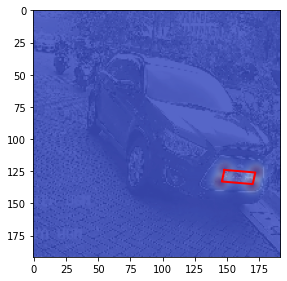

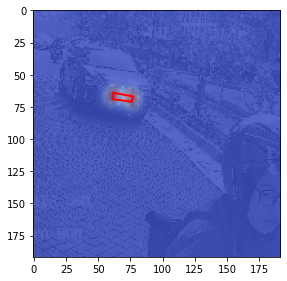

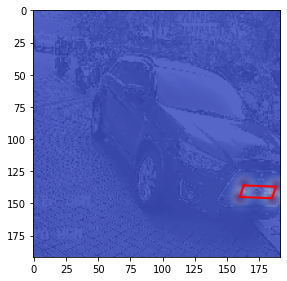

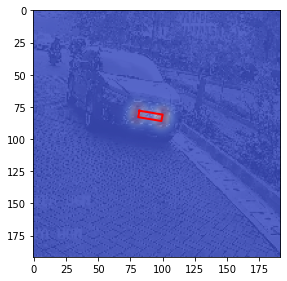

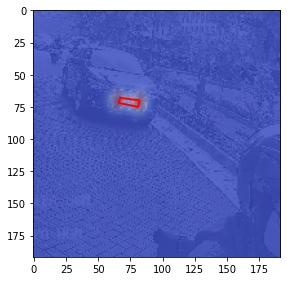

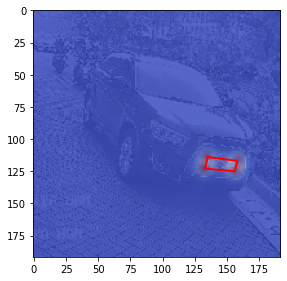

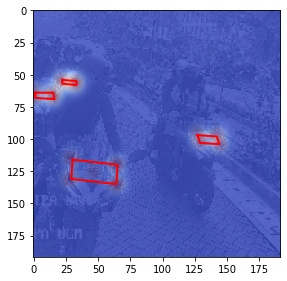

In [29]:
X = h5py.File('Dataset/X_train.hdf5', 'r')
X = np.array(X["default"][:])
X = np.expand_dims(X,axis=-1)

y = h5py.File('Dataset/y_train.hdf5', 'r')
y = np.array(y["default"][:])

with open('Dataset/y_trainLabel.pkl', 'rb') as f:
    y_label = pickle.load(f)

y_label = y_label[:]

for i in range(7):
    keypointTar = groupByobject(y_label[i])
    fig=plt.figure(figsize=(10, 10),frameon=False)
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(np.squeeze(X[i]),cmap='gray')
    ax1.imshow(y[i,:,:,0], alpha=.5, cmap='coolwarm')
    ax1.imshow(y[i,:,:,1], alpha=.4, cmap='coolwarm')
    ax1.imshow(y[i,:,:,2], alpha=.3, cmap='coolwarm')
    ax1.imshow(y[i,:,:,3], alpha=.2, cmap='coolwarm')
    ax1.imshow(y[i,:,:,4], alpha=.1, cmap='coolwarm')
    for j in range(keypointTar.shape[0]):
        xs1 = np.ravel(keypointTar[j,:,:,0].T)
        ys1 = np.ravel(keypointTar[j,:,:,1].T)
        xs1 = np.append(xs1,xs1[0])
        ys1 = np.append(ys1,ys1[0])
        plt.plot(ys1,xs1,c='r',linewidth=2)
    plt.show()

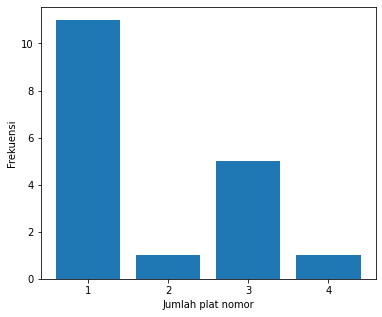

In [41]:
with open('Dataset/y_trainLabel.pkl', 'rb') as f:
    y_label = pickle.load(f)

y_label = y_label[:]
label = [y.shape[1] for y in y_label]

unique,count = np.unique(label,return_counts=True)

unique,count

plt.figure(figsize=(6,5))
plt.bar(unique,count)
plt.xticks(unique)
plt.xlabel("Jumlah plat nomor")
plt.ylabel("Frekuensi")
plt.show()